# Solving the Dual Mot with Neural Networks

Import the packages

In [1]:
%reload_ext autoreload
%autoreload 2
from robust_pricing.deePricing import *
import numpy as np

## Before talking about the trading strategy let's see some generation "strategies"

In [2]:
from robust_pricing.path_generators import Gaussian, GaussianMartingale, Uniform, UniformMartingale
import matplotlib.pyplot as plt

def plot_path(paths):
    T = paths.shape[-1]
    n = paths.shape[0]
    for i in range(n):
        plt.plot(range(1, T + 1), paths[i])

### Simple Gaussian for given $\mu$ and $\Sigma$

In [3]:
mean = 10 * torch.Tensor([1, -1])

rho = -0.4
v1, v2 = 1, 4
variance = torch.Tensor([[v1**0.5, rho*v1**0.5*v2**0.5],[rho*(v1*v2)**0.5, v2**0.5]])
g = Gaussian(path_length=2,mean=mean, variance=variance)
number_of_samples = 1000
x = g(number_of_samples)

tensor([ 10.0345, -10.1084])
tensor([[ 0.9269, -0.7817],
        [-0.7817,  2.0127]])
tensor([[ 1.0000, -0.8000],
        [-0.8000,  2.0000]])


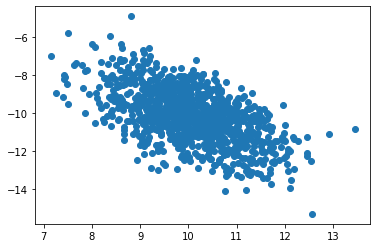

In [4]:
print(x.mean(0))
print(torch.cov(x.T))
print(variance)
plt.scatter(x.select(1, 0), x.select(1, 1))

In [5]:
path_length=20

mean = 100 + torch.rand(path_length)
s = torch.rand(path_length,4)

variance = torch.matmul(s,s.T)

g = Gaussian(path_length=path_length,mean=mean, variance=variance)

/Users/davidcorredor/workspace/OptimalTransport/src/robust_pricing/path_generators/generators.py:42: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646755922314/work/aten/src/ATen/native/Copy.cpp:239.)
  return torch.Tensor(sqrtm(numpy_mat))


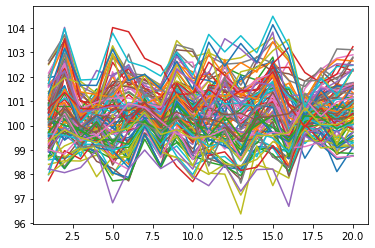

In [6]:
num_paths = 100
plot_path(g(num_paths, path_length))

### Simple Uniform for given $\mu$ and "$\Sigma$"

In [7]:
mean = 10 * torch.Tensor([1, -1])

rho = -0.4
v1, v2 = 1, 4
variance = torch.Tensor([[v1**0.5, rho*v1**0.5*v2**0.5],[rho*(v1*v2)**0.5, v2**0.5]])
g = Uniform(path_length=2,mean=mean, variance=variance)
number_of_samples = 1000
x = g(number_of_samples)

tensor([ 9.9865, -9.9968])
tensor([[ 0.0842, -0.0652],
        [-0.0652,  0.1620]])
tensor([[ 1.0000, -0.8000],
        [-0.8000,  2.0000]])


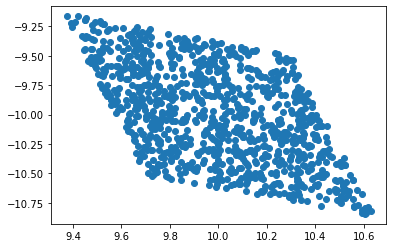

In [8]:
print(x.mean(0))
print(torch.cov(x.T))
print(variance)
plt.scatter(x.select(1, 0), x.select(1, 1))

In [9]:
path_length=20

mean = 100 + torch.rand(path_length)
s = torch.rand(path_length,4)

variance = torch.matmul(s,s.T)

g = Uniform(path_length=path_length,mean=mean, variance=variance)

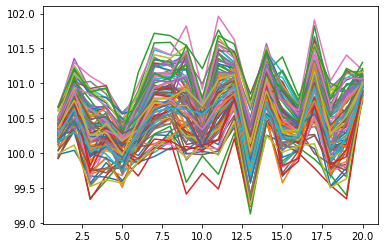

In [10]:
num_paths = 100
plot_path(g(num_paths, path_length))

### "Martingale" Gaussian 

In [11]:
T = 100
n = 1000
gm = GaussianMartingale(T, mean=100, variance=1)
paths = gm(n)

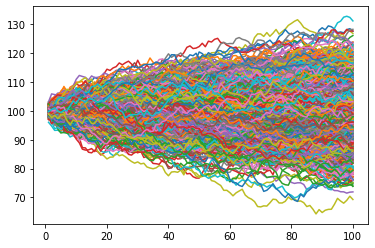

In [12]:
for i in range(n):
    plt.plot(range(1, T + 1), paths[i])

### Martingale Uniform

In [13]:
T = 100
n = 1000
gm = UniformMartingale(T, mean=100, variance=1)
paths = gm(n)

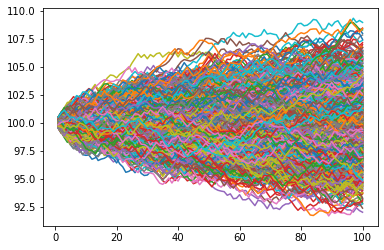

In [14]:
for i in range(n):
    plt.plot(range(1, T + 1), paths[i])

## Modeling $u_t$ as an NN.

Our first step is to model one single $u_t$. We will model this as a portfolio of path independent options that belong to a base set $\mathcal{B}_t$. Based on this we will use 
$$ u_t = \sum_{b\in \mathcal{B_t}}w_bf_b,$$
where $w_b$ are weights that need to be estimated and $f_b$ are the payoff's of the options in $\mathcal{B}_t$.

In this case, the object `OneMaturityOptionPortfolio` models the $u_t$ for a given set of base options. With these options a neural net is constructed that models $u_t: \mathbb{R}\to\mathbb{R}$ in which their parameters are the $w_b$'s. We consider to be a union of only liquid put and call options observed in the market, i.e., $\mathcal{B}_t = P_t \cup C_t$. Under this we formally define the shallow neural network as 
$$ u_t(s) = \sum_{b\in P_t}w_b(K_b-s)^+ + \sum_{b\in C_t}w_b(s-K_b)^+,$$
where $K_b$ is the strike price of the given option.

## Dummy example with made up options

In [15]:
s_0 = 10

p = 0.5

puts_objs = [Put(strike = i, price=p*i/(2 * int(s_0)) + max(0, s_0-i)) for i in range(1, 2 * int(s_0))]
calls_objs = [Call(strike = i, price=p*i/(2 * int(s_0)) + max(0, i - s_0) ) for i in range(1, 2 * int(s_0))]

In [37]:
option = OneMaturityOptionPortfolio(calls_objs, puts_objs)

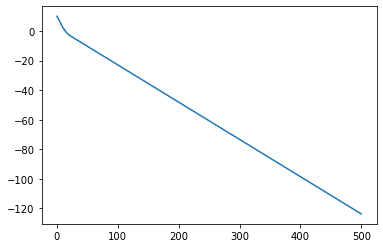

Parameter containing:
tensor([[-0.0244,  0.0751, -0.1587, -0.1117,  0.0426,  0.0855, -0.0400,  0.1201,
         -0.1528,  0.1379,  0.0280, -0.1134, -0.1499,  0.0221,  0.1601, -0.1406,
         -0.0849,  0.1280, -0.0753,  0.0762, -0.0369,  0.0562,  0.0500, -0.0382,
         -0.1151,  0.1131, -0.0182,  0.0528,  0.0379,  0.1433, -0.0266,  0.1553,
         -0.0275,  0.0257,  0.1150, -0.0936,  0.1501,  0.1577]],
       requires_grad=True)

In [38]:
option.visualize_payoff()
list(option.parameters())[0]

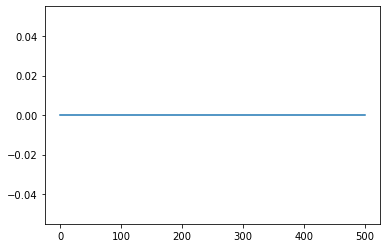

In [40]:
option.reset_weights(zeros=True)
option.visualize_payoff()

In [41]:
generator = Uniform(1, mean=10, variance=10)
option.optimize(
    generator=generator,
    number_of_observations=1000,
    number_of_episodes=100,
)

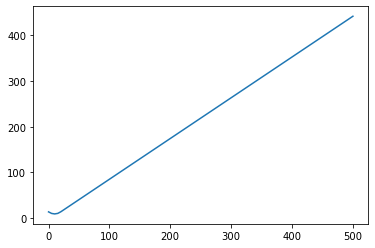

Parameter containing:
tensor([[ 0.1000,  0.1000,  0.1000,  0.1000,  0.0999,  0.0999,  0.0998,  0.0997,
          0.0992,  0.0928, -0.0979,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000, -0.0979,  0.0931,  0.0991,  0.0996,  0.0997,
          0.0998,  0.0998,  0.0998,  0.0999,  0.0999,  0.0999]],
       requires_grad=True)

In [42]:
option.visualize_payoff()
list(option.parameters())[0]

## Now let's try and example with real data.

First we pull some options data. We use AAPL options with maturity 2023-06-16. 

In [ ]:
import pandas as pd
import yfinance as yf
import datetime

yf.pdr_override() 

tk = yf.Ticker('AAPL')
chain = tk.option_chain(date='2023-06-16')
calls = chain.calls
puts = chain.puts
spot_price = tk.history().iloc[0]['Close']

We build the inputs

In [ ]:
calls_objs = [Call(strike=x[1]['strike'], price=x[1]['lastPrice'], bid=x[1]['bid'], ask=x[1]['ask']) for x in calls[['bid', 'strike', 'lastPrice', 'ask']].iterrows()]
puts_objs = [Put(strike=x[1]['strike'], price=x[1]['lastPrice'], bid=x[1]['bid'], ask=x[1]['ask']) for x in puts[['bid', 'strike', 'lastPrice', 'ask']].iterrows()]

In [ ]:
option_portfolio = OneMaturityOptionPortfolio(calls_objs, puts_objs)
option_portfolio.visualize_payoff()
option_portfolio.value

"Loss functoion"

$$ \min_{w}\sum_{b\in \mathcal{B}_t}w_b*\text{price}_b - \frac{1}{N}\sum_{n}u_t(s_n)$$

In [ ]:
sigma = 30
generator = Gaussian(1, mean=spot_price+20, variance=sigma**2)

option_portfolio.optimize(
    generator=generator,
    number_of_observations=1000,
    number_of_episodes=100,
)

In [ ]:
option_portfolio.visualize_payoff()
option_portfolio.value

In [ ]:
option_portfolio(torch.Tensor([[163]])) - option_portfolio.value

## We double check that the pay-off makes sense.

In [ ]:
from quantlib.options.options import CallOption
portfolio = sum([w * o.to_quantlib_object() for o, w in option_portfolio.portfolio.items()], 0 * CallOption(0, 0))

In [ ]:
portfolio.visualizer.payoff()

In [ ]:
# option_portfolio.portfolio


## Now let's use different maturities (No trading strategy $\Delta$ yet)

We start by using data of two options. We use AAPL options with maturity 2023-06-16 and 2023-06-21.

In [ ]:
tk = yf.Ticker('AAPL')
md = tk.history_metadata
spot_price = md['chartPreviousClose']


def create_option_objs_from_yahoo(maturity_date):
    chain = tk.option_chain(date=maturity_date)
    calls = chain.calls
    puts = chain.puts
    calls_objs = [Call(strike=x[1]['strike'], price=x[1]['lastPrice'], bid=x[1]['bid'], ask=x[1]['ask']) for x in calls[['bid', 'strike', 'lastPrice', 'ask']].iterrows()]
    puts_objs = [Put(strike=x[1]['strike'], price=x[1]['lastPrice'], bid=x[1]['bid'], ask=x[1]['ask']) for x in puts[['bid', 'strike', 'lastPrice', 'ask']].iterrows()]
    
    return calls_objs, puts_objs

maturity_dates = ['2023-06-16', '2023-07-21']

# Build the OneMaturityOptionPortfolio objects

option_portfolios = []
for m in maturity_dates:
    o = OneMaturityOptionPortfolio(*create_option_objs_from_yahoo(m))
    option_portfolios.append(o)
    

In [ ]:
calls_objs, puts_objs = create_option_objs_from_yahoo('2023-06-16')

In [ ]:
port = DiagonalOptionPortfolio(option_portfolios)

In [ ]:
print(port.value)
port.visualize_payoff()

In [ ]:
sigma = 30
generator = Gaussian(2, mean=spot_price+30, variance=sigma**2)


port.optimize(
    generator=generator, number_of_observations=1000, number_of_episodes=1000, optimization_kwargs=dict(weight_decay=10000)
)

Visualize the payoff.

In [ ]:
print(port.value)
port.visualize_payoff()

# Now we create the trading strategies $\Delta_t$ 

Each trading strategy will be modeled as a function $\Delta_t: \mathbb{R}^t \to \mathbb{R}$ such that $s_0, s_1, \cdots, s_t\mapsto \Delta(s_0, \cdots, s_t)$, and this value represents the position on the asset to be held until time $t+1$. The structure of this function will be some arbitrary NN structure.

In [ ]:
T = 10
self = TradingStrategy(T)

In [ ]:
n = 1000
gm = GaussianMartingale(T, mean=100, variance=1)
paths = gm(n)

In [ ]:
paths

In [ ]:
self.optimize(generator=gm)

In [ ]:
self.loss_function(gm(n))

# We put all together into the super-hedging strategy $h$

## 1. Get () some options data

In [ ]:
maturity_dates = ['2023-06-16', '2023-07-21', '2023-08-18']

# Build the OneMaturityOptionPortfolio objects

option_portfolios = []
for m in maturity_dates:
    o = OneMaturityOptionPortfolio(*create_option_objs_from_yahoo(m))
    option_portfolios.append(o)

# 2. Create option portfolios

In [ ]:
option_portfolio = DiagonalOptionPortfolio(option_portfolios)

# 3. Create the trading strategy

In [ ]:
trading_strategy = TradingStrategy(time_horizon=option_portfolio.time_horizon)

## 4. Define a "penalty function" $\beta$

In [ ]:
beta = PenaltyFunction(
    initial_gamma=1, 
    penalty_type=PenaltyFunctionTypes.lp_norm,
    penalty_type_kwargs={"p_factor": 2}
)

## 5. Define the exotic option $f$

In [ ]:
K = 100
def f(x):
    return torch.relu(torch.mean(x, 1) - K)

## 6. Create the super-hedging strategy

In [ ]:
h = HedgingStrategy(
    trading_strategy=trading_strategy,
    option_portfolio=option_portfolio,
    target_function=f,
    penalization_function=beta
)

In [ ]:
h.value

## 7. Choose some sample model $\theta$

In [ ]:
gm = GaussianMartingale(h.time_horizon, mean=spot_price, variance=20 ** 2)

## 8. Optimize

In [ ]:
h.optimize(
    generator=gm, 
    number_of_observations=1000, 
    number_of_episodes=500,
#     optimization_kwargs=dict(weight_decay=None)
)

In [ ]:
h.visualize_training_status()

In [ ]:
gm_test = Uniform(h.time_horizon, mean=spot_price, variance=220 ** 2)

In [ ]:
gm_test(10)

In [ ]:
x_test = gm_test(1000)
h.loss_function(x_test)

In [ ]:
h.value

In [ ]:
h.super_replication_error(x_test)

In [ ]:
x_test.min()

In [ ]:
gm_test(100).min()